# PortADa NLP Workshop
# Notebook 02: Embeddings
## Author: Juan Manuel Pérez, 2024

In this notebook we will explore the concept of embeddings and how to use them in NLP tasks. Specifically, we'll be using the `openai` embedding  model to generate embeddings for a given text.}

First of all, let's create an OpenAI account and API key [here](https://platform.openai.com/). Save the API key in some secure place, and just delete after the workshop.


In [3]:
!pip install openai tiktoken


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


Let's load again the data from the previous notebook

In [17]:
# Get API key from getpass
from getpass import getpass

# Set the API key just for this session

api_key = getpass("Enter your API key: ")

In [20]:
import glob
from urllib.request import urlopen
base = "https://raw.githubusercontent.com/finiteautomata/portada_nlp/main/data/lineages"

file_names = [
    "00_the_absolutist_state.txt",
    "01_class_and_state.txt",
    "02_spain.txt",
    "03_france.txt",
    "04_england.txt",
    "05_italy.txt",
    "06_sweden.txt",
    "07_absolutism_in_the.txt",
    "08_nobility_and_monarchy.txt",
    "09_prussia.txt",
    "10_poland.txt",
    "11_austria.txt",
    "12_russia.txt",
    "13_the_house_of.txt",
]

paths = [f"{base}/{file}" for file in file_names]
data = {}
for path in paths:
    # urlopen each file

    with urlopen(path) as f:
        # read the file
        text = f.read().decode("utf-8")

        # Get first paragraph
        first_paragraph, rest = text.split("\n\n", 1)
        title = first_paragraph.split("--")[1].strip()

        data[title] = rest

In [21]:
data.keys()

dict_keys(['The Absolutist State in the West', 'Class and State: Problems of Periodization', 'Spain', 'France', 'England', 'Italy', 'Sweden', 'Absolutism in the East', 'Nobility and Monarchy: the Eastern Variant', 'Prussia', 'Poland', 'Austria', 'Russia', 'The House of Islam'])

## Embeddings

Let's say I want to find passages that talk about "Spanish Feudalism". What can we do?

A good start would be to use an inverse index such as Lucene, ElasticSearch, or even SQLite, and index all the paragraphs of our text. These packages usually rely on an algorithm called [BM-25](https://en.wikipedia.org/wiki/Okapi_BM25), a variant of TF-IDF. TL;DR: these algorithms are word-based and do not understand the "meaning" of words. So for instance, if we search for documents matching "Spanish Feudalism", we will not find documents that talk about "Spanish Serfdom" or "Spanish Manorialism".

An alternative is to use embeddings, which are a way to represent words, sentences or documents as vectors of fixed size. These vectors are such that texts conveying similar meanings will have similar vectors.



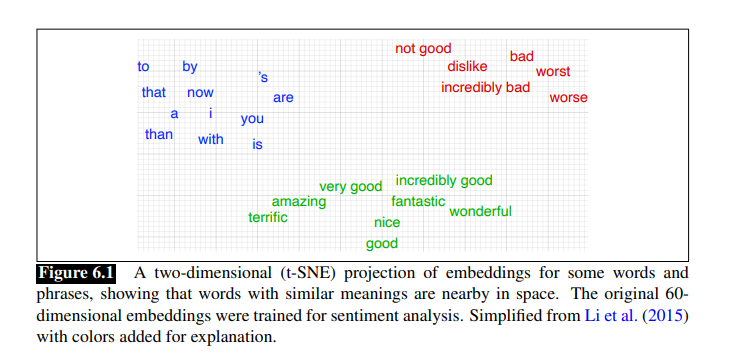

In [30]:
import openai

openai.api_key = api_key

passages = []

for title, text in data.items():
    paragraphs = text.split("\n")
    for p in paragraphs:
        if len(p) < 100:
            continue
        passages.append({
            "title": title,
            "text": p
        })

len(passages)

667

## Tokenization for OpenAI models

OpenAI models use a special tokenization scheme called `BPE` (Byte Pair Encoding). This is a subword tokenization scheme that is able to handle out-of-vocabulary words. These tokenizers are provided by the `tiktoken` library.


In [38]:
import tiktoken

enc = tiktoken.get_encoding("cl100k_base")

tokens = enc.encode("This is a supercalifragilisticexpialidocious sentence.")

tokens

[2028,
 374,
 264,
 2307,
 5531,
 333,
 4193,
 321,
 4633,
 4683,
 532,
 307,
 78287,
 11914,
 13]

In [41]:
# Get the tokens back

for tok in tokens:
    print(enc.decode([tok]))

This
 is
 a
 super
cal
if
rag
il
istic
exp
ial
id
ocious
 sentence
.


Allowing to tokenize the text into these tokens allows us to calculate costs when calling the API.




[]

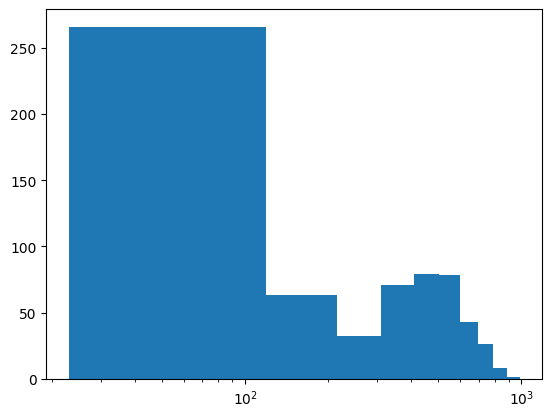

In [42]:
from matplotlib import pyplot as plt

# Histogram of number of tokens in the passages

plt.hist([len(enc.encode(p["text"])) for p in passages])

plt.semilogx()

In [43]:
total_tokens = sum([len(enc.encode(p["text"])) for p in passages])

total_tokens

194543

### Exercise

Check at the [Pricing](https://openai.com/pricing#language-models) page how much it would cost to generate embeddings for this text.

## Generating embeddings/vectors

We are going to use the [`openai` embeddings API](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings) to generate the fixed size vectors.

Particularly, we will use the `text-embedding-3-small`, which is a new (and cheap) model.

In [44]:
# Get embeddings

import openai

embedding_model = "text-embedding-3-small"

embedding = openai.embeddings.create(
    input="This is a test",
    model=embedding_model
)

embedding

CreateEmbeddingResponse(data=[Embedding(embedding=[0.00988506618887186, -0.005540902726352215, 0.0068014683201909065, -0.03810417652130127, -0.018254263326525688, -0.041231658309698105, -0.007651153020560741, 0.03220026567578316, 0.01892443746328354, 0.00010708322952268645, 0.05894339829683304, 0.012478001415729523, -0.023376306518912315, -0.01909995824098587, 0.02549852430820465, 0.029583394527435303, -0.08131444454193115, 0.0017113371286541224, -0.020041393116116524, 0.02832282893359661, 0.02631230652332306, -0.008736196905374527, 0.03954026475548744, 0.0029479677323251963, 0.027365438640117645, -0.042635831981897354, -0.02433369867503643, 0.002638810081407428, 0.022307218983769417, -0.055337224155664444, 0.046720702201128006, -0.03437035158276558, -0.0306524820625782, -0.012837023474276066, -0.01659478433430195, -0.00032935262424871325, -0.00602358765900135, 0.03462565690279007, -0.03357252478599548, 0.0007743900059722364, -0.036061741411685944, -0.052528876811265945, 0.005177891813

In [45]:

len(embedding.data[0].embedding)

1536

This means that each text is represented by a vector of 1536 dimensions.

In [47]:
import numpy as np

documents = [
    "Nobody expects the Spanish Inquisition! -- quote by Monty Python",
    "The quick brown fox jumps over the lazy dog.",
    "Spain has really nice food, particularly paella, tortilla and gazpacho.",
    "Manioralism was a method of land ownership and organization used in medieval Europe, most notably in England and France.",
    "The Black Death was a bubonic plague pandemic occurring in Europe from 1347 to 1351.",
    "Fiefs in the Iberian Peninsula were called 'señoríos'",
    "Rats are usually hunted by cats.",
    "OpenAI is a company that develops artificial intelligence technology.",
    "World Cup 2010 was held in South Africa, and Spain won the tournament.",

]

embeddings = openai.embeddings.create(
    input=documents,
    model=embedding_model
)



In [49]:
embeddings.data

[Embedding(embedding=[0.02451067417860031, 0.014858938753604889, -0.02222266048192978, 0.024839412420988083, -0.05680585280060768, 0.008093519136309624, 0.02285383641719818, 0.019461264833807945, -0.014438154175877571, -0.0573844313621521, -0.011518964543938637, -0.007087582256644964, -0.020552674308419228, 0.06259163469076157, 0.0372919924557209, 0.01113105472177267, -0.02345871366560459, 0.016910260543227196, -0.034320201724767685, 0.035687752068042755, -0.014372407458722591, 0.02345871366560459, -0.030585745349526405, -0.014832640066742897, -0.041236843913793564, -0.03066464141011238, 0.010144841857254505, 0.04420863091945648, 0.028508123010396957, 0.024878859519958496, 0.047548603266477585, -0.019737403839826584, -0.045918066054582596, 0.019001033157110214, -0.0321899838745594, 0.02135479263961315, -0.0074754925444722176, -0.006213140208274126, 0.007620137184858322, 0.020368579775094986, 0.017935922369360924, -0.08105354011058807, -0.02611491270363331, 0.020907709375023842, 0.01775

In [50]:

# We keep the embeddings in a numpy array
vectors = [e.embedding for e in embeddings.data]

vectors = np.array(vectors)

Let's generate a "query" vector and find which of the previous texts are closer to it.

In [51]:
query = "What was feudalism in Spain like?"

query_embedding = openai.embeddings.create(
    input=query,
    model=embedding_model
)

query_vector = query_embedding.data[0].embedding

query_vector = np.array(query_vector)

To check how similar two vectors are, we can use the cosine similarity, which is a measure of the angle between two vectors. Cosine similarity ranges from -1 to 1, where 1 means the vectors are pointing in the same direction, 0 means they are orthogonal, and -1 means they are pointing in opposite directions.

In NLP terms:

- 1 means the texts are conveying the same meaning
- 0 means the texts are unrelated
- -1 means the texts are conveying the opposite meaning

Technical note: as the vectors are normalized, the cosine similarity is just the dot product of the vectors. So `np.dot(v1, v2)` can be translated to `cosine_similarity(v1, v2)`.

In [53]:
# Get cosine similarity (they are already normalized)

def cosine_similarity(a, b):
    return np.dot(a, b)

similarities = cosine_similarity(vectors, query_vector)

for i, s in enumerate(similarities):
    print(f"{s:.2f} --- {documents[i]}")

0.23 --- Nobody expects the Spanish Inquisition! -- quote by Monty Python
0.03 --- The quick brown fox jumps over the lazy dog.
0.35 --- Spain has really nice food, particularly paella, tortilla and gazpacho.
0.39 --- Manioralism was a method of land ownership and organization used in medieval Europe, most notably in England and France.
0.19 --- The Black Death was a bubonic plague pandemic occurring in Europe from 1347 to 1351.
0.50 --- Fiefs in the Iberian Peninsula were called 'señoríos'
0.07 --- Rats are usually hunted by cats.
-0.03 --- OpenAI is a company that develops artificial intelligence technology.
0.25 --- World Cup 2010 was held in South Africa, and Spain won the tournament.


Which of the previous texts are closer to the query vector? 

### Embeddings for "Lineages of the Absolutist State"

Ok, let's do something bigger

In [54]:
embeddings = openai.embeddings.create(
    input=[p["text"] for p in passages],
    model=embedding_model
)


In [56]:
# Convert to numpy array

vectors =[
    e.embedding for e in embeddings.data
]

# Add them to the "passages" dictionary

for i, p in enumerate(passages):
    p["vector"] = vectors[i]


Usually, we use vector databases or indices to search for similar vectors. However, as we are using a small dataset, we can afford to embed the whole dataset and search for similar vectors in memory.

Please remember this is a toy example :)

In [57]:
query = "When did serfdom end in Catalonia?"

query_embedding = openai.embeddings.create(
    input=query,
    model=embedding_model
)

Again, the same thing: let's get the cosine similarity between the query vector and the vectors of the texts.

In [58]:
query_vector = np.array(query_embedding.data[0].embedding)

similarities = np.dot(vectors, query_vector)



In [60]:

import textwrap

k = 10


# Get the indices of the k most similar passages
similarities_idx = np.argsort(similarities)[::-1]

for i in similarities_idx[:k]:
    text = passages[i]["text"]
    # Wrap it to 100 characters
    text = "\n".join(textwrap.wrap(text, 100))

    print("="*80)
    print(f"Similarity: {similarities[i]:.2f}")
    print(f"Title: {vectorized_passages[i]['title']}")
    print(text)


Similarity: 0.50
Title: Spain
But as the military conflict wore on, and the Spanish position worsened, pressure to extract some
Catalan assistance for it became increasingly desperate in Madrid. Olivares therefore determined to
force Catalonia into the war by attacking France across its southeastern frontiers in 1639, thereby
putting the uncooperative province defacto into the front-line of Spanish operations. This reckless
gamble back-fired disastrously.30 The morose and parochial Catalan nobility, starved of remunerative
offices and dabbling in mountain banditry, were enraged by commanders from Castile and casualties
suffered against the French. The lower clergy whipped up regionalist fervour. The peasantry, harried
by billeting and requisitioning, rose against the troops in a spreading insurrection. Rural
labourers and unemployed streaming into the towns set off violent riots in Barcelona and other
cities.31 The Catalan Revolution of 1640 fused the grievances of all social classes e

Let's build a function for it

In [62]:
def get_similarities(query, passages):
    query_embedding = openai.embeddings.create(
        input=query,
        model=embedding_model
    )

    query_vector = np.array(query_embedding.data[0].embedding)

    vectors = np.array([p["vector"] for p in passages])

    similarities = np.dot(vectors, query_vector)

    return similarities

def get_top_k(query, k, passages=passages):
    similarities = get_similarities(query, passages)

    similarities_idx = np.argsort(similarities)[::-1]

    return [(similarities[idx], passages[idx]) for idx in similarities_idx[:k]]

In [63]:
query = "When did serfdom end in Aragon?"

for sim, p in get_top_k(query, 10):
    print("="*80)
    text = p["text"]
    text = "\n".join(textwrap.wrap(text, 100))
    print(f"Similarity: {sim:.2f}")
    print(f"Title: {p['title']}")
    print(text)

Similarity: 0.56
Title: Spain
In Aragon, on the other hand, no political programme of comparable scope was ever attempted. There,
on the contrary, the most that Ferdinand could achieve was a social pacification, and restoration of
the late mediaeval constitution. The remença peasants were finally granted remission of their dues
with the Sentence of Guadelupe in 1486, and rural unrest subsided. Access to the Catalan Diputació
was broadened by the introduction of a sortition system. Otherwise, Ferdinand’s rule unambiguously
confirmed the separate identity of the Eastern realm: Catalan liberties were expressly acknowledged
in their entirety by the Observança of 1481, and new safeguards against royal infractions of them
actually added to the existing arsenal of local weapons against any form of monarchical
centralization. Rarely resident within his native country, Ferdinand installed viceroys in all three
provinces to exercise a delegated authority for him, and created a Council of Aragon,

In [64]:
query = "Was absolutism a transition between feudalism and capitalism?"

for sim, p in get_top_k(query, 10):
    print("="*80)
    text = p["text"]
    text = "\n".join(textwrap.wrap(text, 100))
    print(f"Similarity: {sim:.2f}")
    print(f"Title: {p['title']}\n")
    print(text)

Similarity: 0.69
Title: The Absolutist State in the West

Immensely magnified and reorganized, the feudal State of Absolutism was nevertheless constantly and
profoundly over-determined by the growth of capitalism within the composite social formations of the
early modern period. These formations were, of course, a combination of different modes of
production under the – waning – dominance of one of them: feudalism. All the structures of the
Absolutist State thus reveal the action from a distance of the new economy at work within the
framework of an older system: hybrid ‘capitalizations’ of feudal forms abounded, whose very
perversion of future institutions (army, bureaucracy, diplomacy, trade) was a conversion of past
social objects to repeat them.
Similarity: 0.67
Title: The Absolutist State in the West

These reflections on Absolutism were all more or less casual and allusive: no direct theorization of
the new centralized monarchies which emerged in Renaissance Europe was ever made b

In [67]:
query = "Was Italy a whole kingdom during the Middle Ages?"

for sim, p in get_top_k(query, 10):
    print("="*80)
    text = p["text"]
    text = "\n".join(textwrap.wrap(text, 100))
    print(f"Similarity: {sim:.2f}")
    print(f"Title: {p['title']}\n")
    print(text)

Similarity: 0.54
Title: Italy

The Absolutist State arose in the era of the Renaissance. A great many of its essential techniques –
both administrative and diplomatic – were pioneered in Italy. It is therefore necessary to ask: why
did Italy itself never achieve a national Absolutism? It is clear, of course, that the universalist
mediaeval institutions of the Papacy and the Empire acted to check the development of an orthodox
territorial monarchy in both Italy and Germany. In Italy, the Papacy resisted any attempt at a
territorial unification of the peninsula. However, this in itself would not necessarily have
sufficed to block such an outcome. For the Papacy was notoriously weak for long periods. A strong
French king such as Philippe Le Bel had no difficulty in dealing with it manu militari, by simple
and obvious means – kidnapping at Anagni, captivity at Avignon. It was the absence of any such
ascendant power in Italy which allowed the Papacy’s political manoeuvres. The critical dete